In [746]:
%matplotlib inline

import urllib
import os
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import movingpandas as mpd
import datatable as dt
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.pandas
import time as time

from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from fiona.crs import from_epsg
from datetime import datetime, timedelta
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from holoviews import opts
from sklearn.linear_model import LinearRegression
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))

import warnings
warnings.simplefilter("ignore")
CRS_METRIC = from_epsg(4326)

In [664]:
feats = pd.read_csv('final_dataset_rev_full_features.csv')
feats.drop(columns=['Unnamed: 0'], inplace=True)
print('Finished reading {} records'.format(len(feats)))

Finished reading 3752393 records


convert speed in mile/h to m/s

In [760]:
feats['speed'] = feats['speed'].apply(lambda x: x/2.237)

In [761]:
feats.head()

,time,mmsi,speed,course,turn,lon,lat,id
0,2019-12-13 08:43:00,0,3.033675,281.979856,-128.0,103.675535,1.199979,1
1,2019-12-13 08:44:00,0,3.110860,130.339568,-128.0,103.675565,1.201917,1
2,2019-12-13 08:45:00,0,3.181222,7.427869,-128.0,103.675868,1.203762,1
3,2019-12-13 08:46:00,0,3.221195,12.488972,-128.0,103.677381,1.205190,1
4,2019-12-13 08:47:00,0,3.261167,17.550075,-128.0,103.678895,1.206618,1


In [762]:
uni_values = feats.iloc[:, [2, 3, 4, -3, -2]].values
uni_values[0]

array([   3.03367498,  281.97985612, -128.        ,  103.67553511,
          1.19997906])

In [763]:
train_size_temp = int(len(uni_values) * 0.8)
test_size = len(uni_values) - train_size_temp
valid_size = int(train_size_temp * 0.25)
train_size = train_size_temp - valid_size

In [768]:
train_temp, test = uni_values[:train_size_temp, :], uni_values[train_size_temp:len(uni_values), :]
train, valid = train_temp[:train_size, :], train_temp[train_size:train_size_temp, :]

df_train_temp, df_test = feats[:train_size_temp], feats[train_size_temp:len(uni_values)]
df_train, df_valid = feats[:train_size], feats[train_size:train_size_temp]
print('Train {} Test {} Valid {}: '.format(len(train), len(test), len(valid)))

Train 2251436 Test 750479 Valid 750478: 


In [769]:
sc_train = StandardScaler().fit(train)
train_norm = sc_train.transform(train)
valid_norm = sc_train.transform(valid)
test_norm = sc_train.transform(test)

# create datasets
data_train = merge_with_mmsi(train_norm, df_train)
data_valid = merge_with_mmsi(valid_norm, df_valid)
data_test = merge_with_mmsi(test_norm, df_test)

(array([2.34000e+02, 1.46070e+04, 3.31270e+04, 9.87280e+04, 2.81121e+05,
        5.91585e+05, 8.18694e+05, 4.13057e+05, 2.74000e+02, 9.00000e+00]),
 array([-5.23197354, -4.35519111, -3.47840869, -2.60162627, -1.72484385,
        -0.84806143,  0.028721  ,  0.90550342,  1.78228584,  2.65906826,
         3.53585069]),
 <a list of 10 Patch objects>)

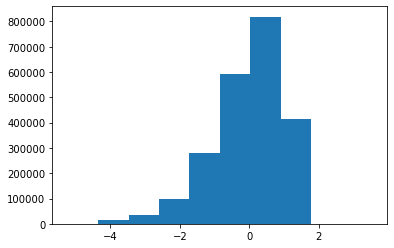

In [770]:
plt.hist(train_norm[:,4])

In [771]:
data_train

,0,1,2,3,4,id
0,0.729463,0.952307,-1.347387,-0.486669,-0.894245,1
1,0.762980,-0.560336,-1.347387,-0.486270,-0.857308,1
2,0.793535,-1.786406,-1.347387,-0.482285,-0.822153,1
3,0.810893,-1.735920,-1.347387,-0.462322,-0.794938,1
4,0.828251,-1.685435,-1.347387,-0.442359,-0.767722,1
...,...,...,...,...,...,...
2251431,0.421522,1.021441,2.196378,-0.544765,-0.946422,17639
2251432,0.421522,1.061860,0.705379,-0.563261,-0.936770,17639
2251433,0.417073,1.049226,0.581129,-0.581303,-0.926488,17639
2251434,0.412220,1.031769,0.581129,-0.599303,-0.916149,17639


In [793]:
def generate_all_datasets(df, history_size, target_size, single_step):
    X = []
    y = []

    idx_list = df['id'].unique()

    for idx in idx_list:
        data_temp = df.loc[df['id'] == idx]
        X_temp, y_temp = create_datasets(data_temp, history_size, target_size, single_step)
        X.extend(X_temp)
        y.extend(y_temp)
    return np.array(X), np.array(y)

def create_datasets(df, lookback, target_size, single_step):
    # normalize the input
    input_data = df.iloc[:, [0, 1, 2, 3, 4]].values
    X = []
    y = []
    start_index = lookback
    end_index = len(input_data) - target_size
    for i in range(start_index, end_index):
        indices = range(i-lookback, i)
        X.append(input_data[indices])
        if single_step:
            y.append(input_data[i + target_size - 1, -2:])
        else:
            y.append(input_data[i:i + target_size, -2:].reshape(target_size*2))
    return X, y

In [794]:
x_train_single, y_train_single = generate_all_datasets(data_train, 20, 10, False)

In [803]:
y_train_single.shape

(1758326, 20)

In [670]:
feats['time'] = pd.to_datetime(feats['time']).dt.tz_localize(None)

In [737]:
feats['mmsi'].sort_values()

0                  0
25                 0
26                 0
27                 0
28                 0
             ...    
3752292    710033240
3752293    710033240
3752294    710033240
3752287    710033240
3752392    710033240
Name: mmsi, Length: 3752393, dtype: int64

In [666]:
len(feats.id.unique()), len(feats.mmsi.unique())

(26566, 3807)

In [219]:
df = pd.read_csv('final_dataset_rev_id.csv')
print('Finished reading {} records'.format(len(df)))

Finished reading 2965366 records


In [320]:
df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)

In [306]:
def get_lon(point):
    return float(point.strip("")[6:].strip('()').split()[0])
def get_lat(point):
    return float(point.strip("")[6:].strip('()').split()[1])

In [321]:
df['lon'] = df.geometry.apply(lambda x: get_lon(x))
df['lat'] = df.geometry.apply(lambda x: get_lat(x))
df['t'] = df.time.astype('int64') // 10**9 - 28800

In [322]:
df.head()

,time,mmsi,geometry,id,lon,lat,t
0,2019-12-04 21:23:20,5631127,POINT (103.77934 1.28308),6,103.77934,1.28308,1575465800
1,2019-12-04 21:35:29,5631127,POINT (103.77925 1.28326),6,103.77925,1.28326,1575466529
2,2019-12-04 21:37:30,5631127,POINT (103.77931 1.28309),6,103.77931,1.28309,1575466650
3,2019-12-04 21:39:03,5631127,POINT (103.77925 1.28316),6,103.77925,1.28316,1575466743
4,2019-12-04 21:45:43,5631127,POINT (103.77936 1.28312),6,103.77936,1.28312,1575467143


In [652]:
figure = df.copy()

In [656]:
figure = figure[['time', 't', 'mmsi', 'id', 'lon', 'lat']]
figure.columns = ['time', 'timestamp', 'mmsi_id', 'track_id', 'longitude', 'latitude']

In [659]:
figure.head(5)

,time,timestamp,mmsi_id,track_id,longitude,latitude
0,2019-12-04 21:23:20,1575465800,5631127,6,103.77934,1.28308
1,2019-12-04 21:35:29,1575466529,5631127,6,103.77925,1.28326
2,2019-12-04 21:37:30,1575466650,5631127,6,103.77931,1.28309
3,2019-12-04 21:39:03,1575466743,5631127,6,103.77925,1.28316
4,2019-12-04 21:45:43,1575467143,5631127,6,103.77936,1.28312


In [ ]:
\begin{figure}[t!]
\centering
\begin{subfigure}{5cm}
  \centering
  \includegraphics[width=5cm]{pic/ch-Univariate/dataset_random.png}
  \caption{Before sorted by track id}
  \label{fig:dataset_sub1}
\end{subfigure}
%
\begin{subfigure}{5cm}
  \centering
  \includegraphics[width=5cm]{pic/ch-Univariate/dataset_head.png}
  \caption{After sorted by track id}
  \label{fig:dataset_sub2}
\end{subfigure}
\caption{Pre-preocessed AIS dataset}
\label{fig:dataset}
\end{figure}

In [661]:
figure.tail()

,time,timestamp,mmsi_id,track_id,longitude,latitude
2965361,2019-12-22 02:50:49,1576954249,710032990,28386,103.58687,1.19609
2965362,2019-12-22 02:51:30,1576954290,710032990,28386,103.58443,1.19644
2965363,2019-12-22 02:52:09,1576954329,710032990,28386,103.58204,1.19678
2965364,2019-12-22 02:54:49,1576954489,710032990,28386,103.57219,1.19827
2965365,2019-12-22 03:00:50,1576954850,710032990,28386,103.54981,1.20144


In [663]:
figure.sample(5)

,time,timestamp,mmsi_id,track_id,longitude,latitude
2859931,2019-12-22 05:33:35,1576964015,567413000,27037,103.66920,1.19593
1204382,2019-12-21 01:35:04,1576863304,563032960,12556,103.74865,1.28898
2813651,2019-12-20 05:23:59,1576790639,566751000,26485,103.65561,1.24696
132805,2019-12-30 01:15:54,1577639754,319017500,1817,103.66513,1.23283
2595305,2019-12-21 18:56:57,1576925817,566135000,24436,103.72225,1.21621


In [323]:
len(df.id.unique()), len(df.mmsi.unique())

(10812, 2584)

In [327]:
dataset = df[['t', 'id', 'lon', 'lat']]

In [328]:
dataset.head()

,t,id,lon,lat
0,1575465800,6,103.77934,1.28308
1,1575466529,6,103.77925,1.28326
2,1575466650,6,103.77931,1.28309
3,1575466743,6,103.77925,1.28316
4,1575467143,6,103.77936,1.28312


In [633]:
def sortByMmsi(df):
    val = df['mmsi'].value_counts().tolist()
    idx = df['mmsi'].value_counts().index.tolist()
    val_idx = dict(zip(idx, val))

    frames = []
    for mmsi, length in val_idx.items():
        dfn = df[df['mmsi']==mmsi]
        frames.append(dfn)
    df_sort = pd.concat(frames)
    return df_sort

def merge_with_mmsi(data, df):
    df_data = pd.DataFrame(data)
    df_data['id'] = df.reset_index()['id']

    return df_data

def plot(act, pred, test=False):
    t = np.arange(len(pred))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(t, act, 'b', label='Actual')
    plt.plot(t, pred, 'r', label='Predict')
    plt.xlabel('time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [330]:
all_temp = []
for idx in dataset['id'].unique():
    temp = dataset.loc[dataset['id']==idx].reset_index()
    deltaT = temp.t.diff()
    deltaT = np.concatenate((np.array([0]), deltaT[1:]))
    temp.insert(1, '∆t', deltaT)
    all_temp.append(temp)

final = pd.concat(all_temp)

In [332]:
final = final[['t', '∆t', 'id', 'lon', 'lat']]

In [333]:
final.head()

,t,∆t,id,lon,lat
0,1575465800,0.0,6,103.77934,1.28308
1,1575466529,729.0,6,103.77925,1.28326
2,1575466650,121.0,6,103.77931,1.28309
3,1575466743,93.0,6,103.77925,1.28316
4,1575467143,400.0,6,103.77936,1.28312


In [337]:
final.iloc[:, [1, 3, 4]]

,∆t,lon,lat
0,0.0,103.77934,1.28308
1,729.0,103.77925,1.28326
2,121.0,103.77931,1.28309
3,93.0,103.77925,1.28316
4,400.0,103.77936,1.28312
...,...,...,...
187,40.0,103.58687,1.19609
188,41.0,103.58443,1.19644
189,39.0,103.58204,1.19678
190,160.0,103.57219,1.19827


In [355]:
from sklearn.preprocessing import StandardScaler

final_values = final.iloc[:, [1, 3, 4]].values

train_size = int(len(final_values) * 0.8)
train = final_values[:train_size]
test = final_values[train_size:]

df_train = final[:train_size]
df_test = final[train_size:]
print('Train: {} Test: {}'.format(len(train), len(test)))

sc_train = StandardScaler().fit(train)
train_norm = sc_train.transform(train)
test_norm = sc_train.transform(test)

# create datasets
data_train = merge_with_mmsi(train_norm, df_train)
data_test = merge_with_mmsi(test_norm, df_test)

Train: 2372292 Test: 593074


In [557]:
data_train.head(6)

,0,1,2,id
0,-0.539013,0.896525,0.673833,6
1,7.039163,0.895196,0.677396,6
2,0.718819,0.896082,0.674031,6
3,0.427750,0.895196,0.675416,6
4,3.619108,0.896820,0.674625,6
5,5.760541,0.896082,0.673635,6


In [707]:
def generate_all_datasets(df, history_size, target_size, single_step):
    X = []
    y = []

#     idx_list = df['id'].value_counts().index.tolist()
    idx_list = df['id'].unique()

    for mmsi in idx_list:
        data_temp = df.loc[df['id'] == mmsi]
        X_temp, y_temp = create_datasets(data_temp, history_size, target_size, single_step)
        X.extend(X_temp)
        y.extend(y_temp)
    return np.array(X), np.array(y)

def re_init(arr):
    '''
    Helper function to initializate to 0 a vector
    '''
    arr = np.cumsum(arr)
    return arr - arr[0]

def create_datasets(df, lookback, target_size, single_step):
    # normalize the input
    input_data = df.iloc[:, [0, 1, 2]].values

    X = []
    y = []
    start_index = lookback
    end_index = len(input_data) - target_size
    for i in range(start_index, end_index):
        indices = range(i-lookback, i)
#         transform time as cumulative sum to indicate features-time dependency
        time = re_init(input_data[indices, 0]).reshape(-1,1)
        slices = np.concatenate((time, input_data[indices, 1:]), axis=1)
        X.append(slices)
#         X.append(input_data[indices])
        if single_step:
#             time = (input_data[i + target_size - 1, 0] + time[-1])
#             slices = np.concatenate((time, input_data[i + target_size - 1, 1:]), axis=0)
#             y.append(slices)
            y.append(input_data[i + target_size - 1, :])
        else:
            y.append(input_data[i:i + target_size, :].reshape(target_size*2))
    return X, y

In [705]:
def experiment(past_history, future_target):
    x_train_single, y_train_single = generate_all_datasets(data_train, past_history, future_target, True)
    x_test_single, y_test_single = generate_all_datasets(data_test, past_history, future_target, True)
    
    print(x_train_single.shape, y_train_single.shape)
    
    return x_train_single, y_train_single
    
#     x_train = x_train_single.reshape((-1, past_history*3), order='F')
#     y_time_train = y_train_single[:,0].reshape(-1,1)
#     y_lon_train = y_train_single[:,1].reshape(-1,1)
#     y_lat_train = y_train_single[:,2].reshape(-1,1)
#     x_train = np.concatenate((x_train, y_time_train), axis=1)
#     y_train_lon = y_lon_train
#     y_train_lat = y_lat_train
    
#     x_test = x_test_single.reshape((-1, past_history*3), order='F')

#     y_time_test = y_test_single[:,0].reshape(-1,1)
#     y_lon_test = y_test_single[:,1].reshape(-1,1)
#     y_lat_test = y_test_single[:,2].reshape(-1,1)

#     x_test = np.concatenate((x_test, y_time_test), axis=1)
#     y_test_lon = y_lon_test
#     y_test_lat = y_lat_test
    
#     print(x_train.shape, y_train_lon.shape, x_test.shape, y_test_lon.shape)
#     return x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat

def MLP(x_train, y_train, x_test, y_test):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)

    t0 = time.time()
    lr_y = y_test
    lr_y_fit = lr_model.predict(x_train)
    lr_y_pred = lr_model.predict(x_test)
    tF = time.time()

    lr_residuals = lr_y_pred - lr_y
    lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
    lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
    lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)
    print('RMSE = %.5f' % lr_rmse)
    print('MAE = %.5f' % lr_mae)
    print('MAPE = %.5f' % lr_mape)
    print('Time to train = %.2f seconds' % (tF - t0))
    
def error_MLP(x_train, y_train, x_test, y_test):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)

    t0 = time.time()
    lr_y = y_test
    lr_y_fit = lr_model.predict(x_train)
    lr_y_pred = lr_model.predict(x_test)
    tF = time.time()

    lr_residuals = lr_y_pred - lr_y
    lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
    lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
    lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)

    lr_sq_err = np.sum(np.power(lr_residuals,2))
    lr_abs_err = np.sum(np.absolute(lr_residuals))
    lr_abs_perc_err = np.sum(np.absolute(lr_residuals / lr_y))
    print('RMSE = %.5f' % lr_rmse)
    print('MAE = %.5f' % lr_mae)
    print('MAPE = %.5f' % lr_mape)
    print('Time to train = %.2f seconds' % (tF - t0))
#     plot(lr_y, lr_y_pred, True)
    return lr_sq_err, lr_abs_err, lr_abs_perc_err, len(lr_residuals)

### Multiple Linear Regression

time step = 1

In [625]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(1, 1)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(2355020, 4) (2355020, 1) (588720, 4) (588720, 1)
RMSE = 0.08230
MAE = 0.01134
MAPE = 0.06376
Time to train = 0.03 seconds
RMSE = 0.09731
MAE = 0.01421
MAPE = 0.08731
Time to train = 0.03 seconds
Total RMSE = 0.09012
Total MAE = 0.01278
Total MAPE = 0.07553


In [577]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(1, 1)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(2355020, 4) (2104576, 1) (588720, 4) (525587, 1)
RMSE = 0.08230
MAE = 0.01134
MAPE = 0.06370
Time to train = 0.04 seconds
RMSE = 0.09731
MAE = 0.01421
MAPE = 0.08732
Time to train = 0.03 seconds
Total RMSE = 0.09012
Total MAE = 0.01278
Total MAPE = 0.07551


In [539]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(1)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(2355020, 4) (2104576, 1) (588720, 4) (525587, 1)
RMSE = 0.08230
MAE = 0.01134
MAPE = 0.06370
Time to train = 0.03 seconds
RMSE = 0.09731
MAE = 0.01421
MAPE = 0.08732
Time to train = 0.03 seconds
Total RMSE = 0.09012
Total MAE = 0.01278
Total MAPE = 0.07551


time step = 10

In [709]:
x_train, y_train = experiment(4, 1)
# x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(4, 1)
# # lon
# sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# # lat
# sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# # rmse, mae, mape
# lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
# lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
# lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
# print('Total RMSE = %.5f' % lr_total_rmse)
# print('Total MAE = %.5f' % lr_total_mae)
# print('Total MAPE = %.5f' % lr_total_mape)

(2329112, 4, 3) (2329112, 3)


In [736]:
# orig = np.concatenate((x_train[0:5], y_train[0:5,1].reshape(-1,1)), axis=1)
# pd.DataFrame(data=, orig)
# y_train[0:5,1].reshape(-1,1)
# x_train[0], y_train[0]
train = data_train.iloc[:, :-1].copy()
train.columns = ['∆t', 'lon', 'lat']
# train['∆t'] = re_init(train['∆t'])
train.head(10)

,∆t,lon,lat
0,-0.539013,0.896525,0.673833
1,7.039163,0.895196,0.677396
2,0.718819,0.896082,0.674031
3,0.427750,0.895196,0.675416
4,3.619108,0.896820,0.674625
5,5.760541,0.896082,0.673635
6,3.307249,0.897706,0.675416
7,1.228189,0.895639,0.674823
8,1.955860,0.896377,0.674823
9,0.708423,0.895196,0.674031


In [694]:
w = 4
r = 1
features = ['∆t', 'lon', 'lat']
cols = len(features) - 1
p = cols * w
names = []

for j, col in enumerate(features):
    for i in range(w):
        name = col + ('(%d)' % (i+1))
        names.append(name)

name = '∆t' + ('(%d)' % (w + r))
names.append(name)
name = 'Y'
names.append(name)

print(len(names))

14


In [696]:
data = np.concatenate((x_train[0:5], y_train_lon[0:5]), axis=1)
pd.DataFrame(data=data, columns=names)

,∆t(1),∆t(2),∆t(3),∆t(4),lon(1),lon(2),lon(3),lon(4),lat(1),lat(2),lat(3),lat(4),∆t(5),Y
0,0.0,7.039163,7.757982,8.185732,0.896525,0.895196,0.896082,0.895196,0.673833,0.677396,0.674031,0.675416,11.804840,0.896820
1,0.0,0.718819,1.146569,4.765677,0.895196,0.896082,0.895196,0.896820,0.677396,0.674031,0.675416,0.674625,10.526218,0.896082
2,0.0,0.427750,4.046859,9.807399,0.896082,0.895196,0.896820,0.896082,0.674031,0.675416,0.674625,0.673635,13.114649,0.897706
3,0.0,3.619108,9.379649,12.686898,0.895196,0.896820,0.896082,0.897706,0.675416,0.674625,0.673635,0.675416,13.915087,0.895639
4,0.0,5.760541,9.067790,10.295979,0.896820,0.896082,0.897706,0.895639,0.674625,0.673635,0.675416,0.674823,12.251838,0.896377


In [700]:
x_train[0]

array([ 0.        ,  7.03916309,  7.75798183,  8.18573208,  0.89652503,
        0.89519646,  0.89608218,  0.89519646,  0.67383289,  0.67739553,
        0.67403081,  0.67541628, 11.80484041])

In [632]:
x_train[0], y_train_lon[0]

(array([ 0.        ,  7.03916309,  7.75798183,  8.18573208, 11.80484041,
        17.56538121, 20.87263045, 22.10081905, 24.05667887, 24.7651023 ,
         0.89652503,  0.89519646,  0.89608218,  0.89519646,  0.89682027,
         0.89608218,  0.89770599,  0.89563932,  0.89637742,  0.89519646,
         0.67383289,  0.67739553,  0.67403081,  0.67541628,  0.67462458,
         0.67363496,  0.67541628,  0.67482251,  0.67482251,  0.67403081,
        25.47352574]),
 array([0.89608218]))

In [540]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(10)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(2277296, 31) (2104576, 1) (569127, 31) (525587, 1)
RMSE = 0.07094
MAE = 0.01191
MAPE = 0.08662
Time to train = 0.10 seconds
RMSE = 0.08119
MAE = 0.01629
MAPE = 0.11648
Time to train = 0.09 seconds
Total RMSE = 0.07624
Total MAE = 0.01410
Total MAPE = 0.10155


time step = 20

In [541]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(20)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(2190936, 61) (2104576, 1) (547357, 61) (525587, 1)
RMSE = 0.06888
MAE = 0.01130
MAPE = 0.08289
Time to train = 0.48 seconds
RMSE = 0.07907
MAE = 0.01568
MAPE = 0.11467
Time to train = 0.40 seconds
Total RMSE = 0.07415
Total MAE = 0.01349
Total MAPE = 0.09878


time step = 30

In [542]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(30)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(2104576, 91) (2104576, 1) (525587, 91) (525587, 1)
RMSE = 0.06765
MAE = 0.01095
MAPE = 0.08261
Time to train = 2.63 seconds
RMSE = 0.07839
MAE = 0.01528
MAPE = 0.11276
Time to train = 0.34 seconds
Total RMSE = 0.07322
Total MAE = 0.01312
Total MAPE = 0.09768


time step = 60

In [543]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(60)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(1911547, 181) (2104576, 1) (476043, 181) (525587, 1)
RMSE = 0.06563
MAE = 0.01024
MAPE = 0.07519
Time to train = 12.68 seconds
RMSE = 0.07664
MAE = 0.01457
MAPE = 0.11157
Time to train = 16.26 seconds
Total RMSE = 0.07135
Total MAE = 0.01241
Total MAPE = 0.09338


Multi-step prediction

(2035580, 91) (2035580, 1) (507942, 91) (507942, 1)
RMSE = 0.11202
MAE = 0.03538
MAPE = 0.26748
Time to train = 3.53 seconds


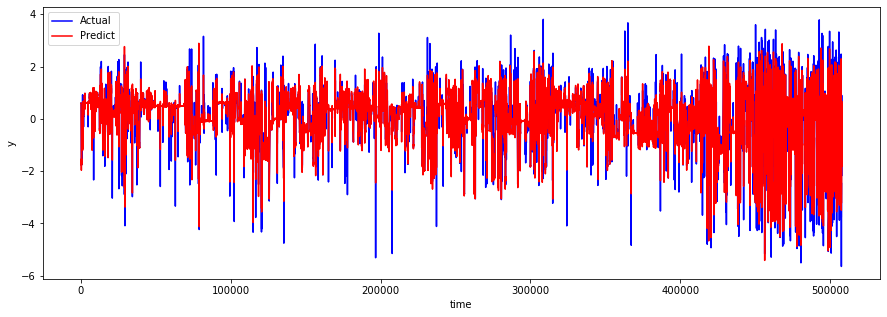

RMSE = 0.12408
MAE = 0.04680
MAPE = 0.33480
Time to train = 0.29 seconds


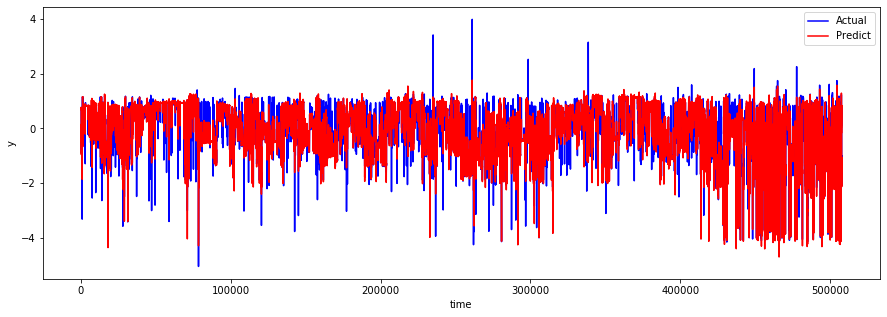

Total RMSE = 0.11820
Total MAE = 0.04109
Total MAPE = 0.30114


In [635]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(30, 10)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

In [547]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(30, 20)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(1971740, 91) (2104576, 1) (491578, 91) (525587, 1)
RMSE = 0.16263
MAE = 0.06086
MAPE = 0.58138
Time to train = 0.72 seconds
RMSE = 0.17524
MAE = 0.08026
MAPE = 0.58400
Time to train = 0.21 seconds
Total RMSE = 0.16905
Total MAE = 0.07056
Total MAPE = 0.58269


In [546]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(30, 30)
# lon
sq_err_lon, abs_err_lon, abs_perc_err_lon, len_longitude = error_MLP(x_train, y_train_lon, x_test, y_test_lon)
# lat
sq_err_lat, abs_err_lat, abs_perc_err_lat, len_latitude = error_MLP(x_train, y_train_lat, x_test, y_test_lat)

# rmse, mae, mape
lr_total_rmse = np.sqrt((sq_err_lon + sq_err_lat) / (len_longitude + len_latitude))
lr_total_mae = (abs_err_lon + abs_err_lat) / (len_longitude + len_latitude)
lr_total_mape = (abs_perc_err_lon + abs_perc_err_lat) / (len_longitude + len_latitude)
print('Total RMSE = %.5f' % lr_total_rmse)
print('Total MAE = %.5f' % lr_total_mae)
print('Total MAPE = %.5f' % lr_total_mape)

(1916688, 91) (2104576, 1) (477381, 91) (525587, 1)
RMSE = 0.20917
MAE = 0.08524
MAPE = 0.74590
Time to train = 0.21 seconds
RMSE = 0.22071
MAE = 0.11050
MAPE = 0.78504
Time to train = 0.19 seconds
Total RMSE = 0.21502
Total MAE = 0.09787
Total MAPE = 0.76547


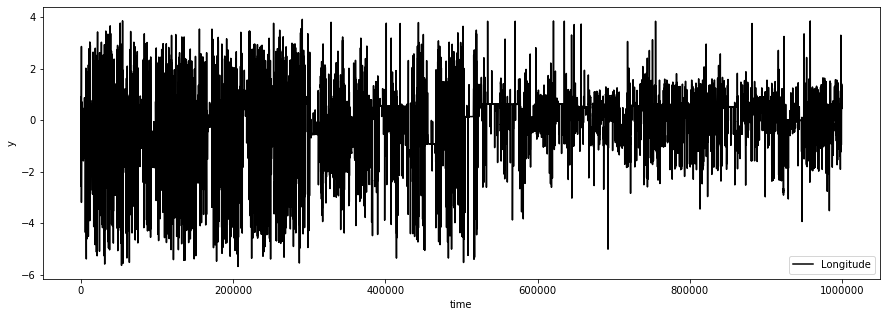

In [651]:
test = y_train_lon[0:1000000]
t = np.arange(len(test))
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, test, 'k', label='Longitude')
plt.xlabel('time')
plt.ylabel('y')
plt.legend()
plt.show()

In [472]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

t0 = time.time()
lr_y = y_test
lr_y_fit = lr_model.predict(x_train)
lr_y_pred = lr_model.predict(x_test)
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)
print('RMSE = %.5f' % lr_rmse)
print('MAE = %.5f' % lr_mae)
print('MAPE = %.5f' % lr_mape)
print('Time to train = %.2f seconds' % (tF - t0))

RMSE = 0.07292
MAE = 0.01407
MAPE = 0.10669
Time to train = 0.05 seconds


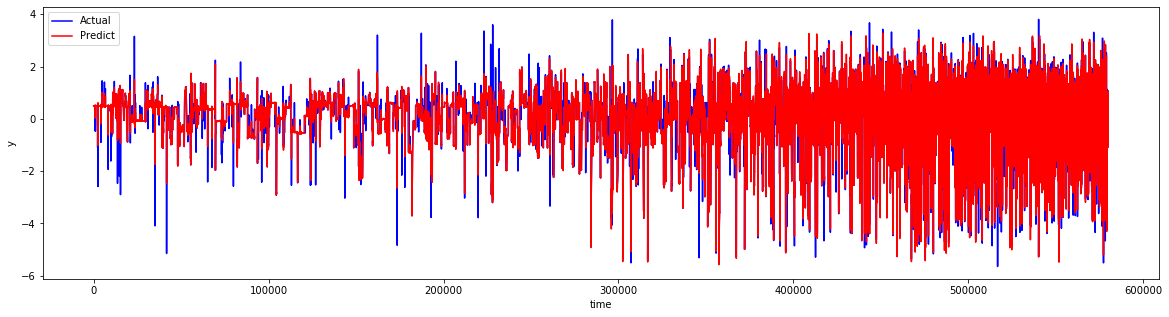

In [478]:
plot(lr_y, lr_y_pred, True)

In [500]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

t0 = time.time()
lr_y = y_test
lr_y_fit = lr_model.predict(x_train)
lr_y_pred = lr_model.predict(x_test)
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)
print('RMSE = %.5f' % lr_rmse)
print('MAE = %.5f' % lr_mae)
print('MAPE = %.5f' % lr_mape)
print('Time to train = %.2f seconds' % (tF - t0))

RMSE = 0.08230
MAE = 0.01134
MAPE = 0.06370
Time to train = 0.03 seconds


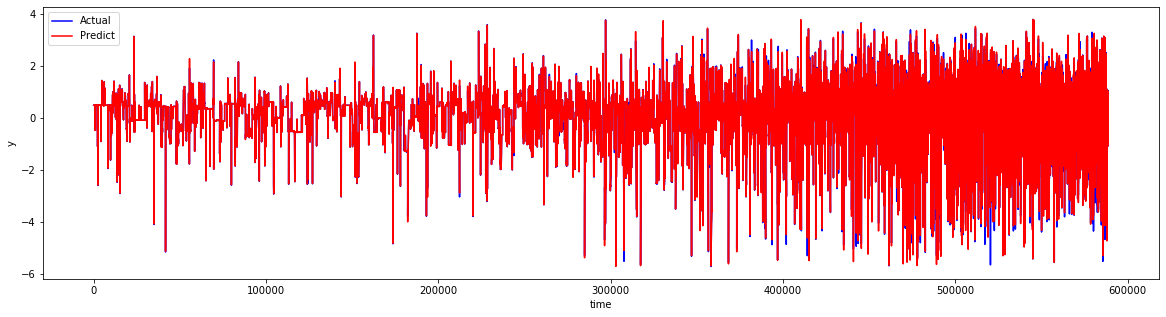

In [501]:
plot(lr_y, lr_y_pred, True)

RMSE = 0.07094
MAE = 0.01191
MAPE = 0.08662
Time to train = 0.82 seconds


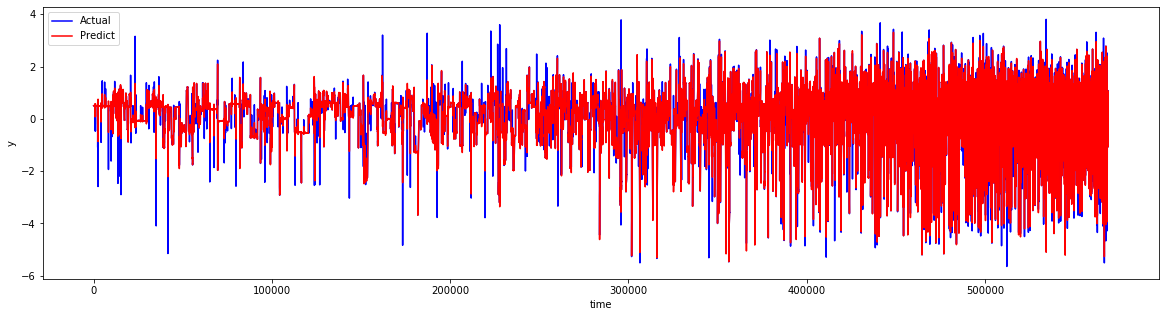

In [507]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

t0 = time.time()
lr_y = y_test
lr_y_fit = lr_model.predict(x_train)
lr_y_pred = lr_model.predict(x_test)
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)
print('RMSE = %.5f' % lr_rmse)
print('MAE = %.5f' % lr_mae)
print('MAPE = %.5f' % lr_mape)
print('Time to train = %.2f seconds' % (tF - t0))

plot(lr_y, lr_y_pred, True)

(2190936, 61) (2190936, 1) (547357, 61) (547357, 1)
RMSE = 0.06888
MAE = 0.01130
MAPE = 0.08289
Time to train = 0.27 seconds


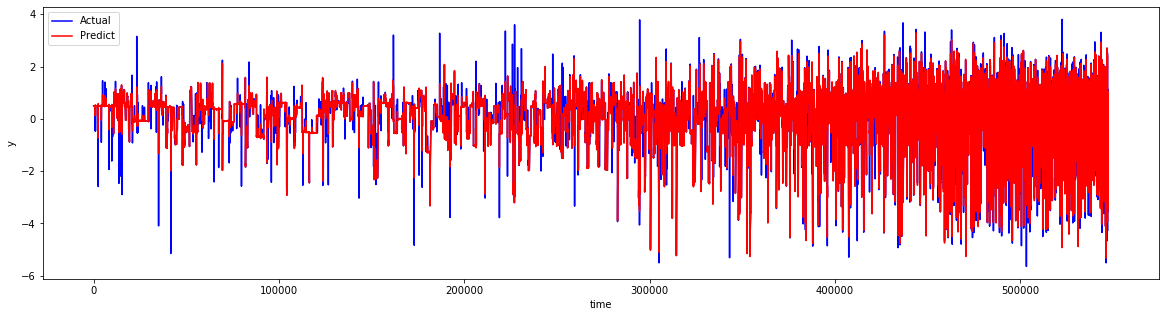

In [511]:
x_train, y_train, x_test, y_test = experiment(20)

# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

t0 = time.time()
lr_y = y_test
lr_y_fit = lr_model.predict(x_train)
lr_y_pred = lr_model.predict(x_test)
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)
print('RMSE = %.5f' % lr_rmse)
print('MAE = %.5f' % lr_mae)
print('MAPE = %.5f' % lr_mape)
print('Time to train = %.2f seconds' % (tF - t0))

plot(lr_y, lr_y_pred, True)

(2104576, 91) (2104576, 1) (525587, 91) (525587, 1)
RMSE = 0.06765
MAE = 0.01095
MAPE = 0.08261
Time to train = 0.86 seconds


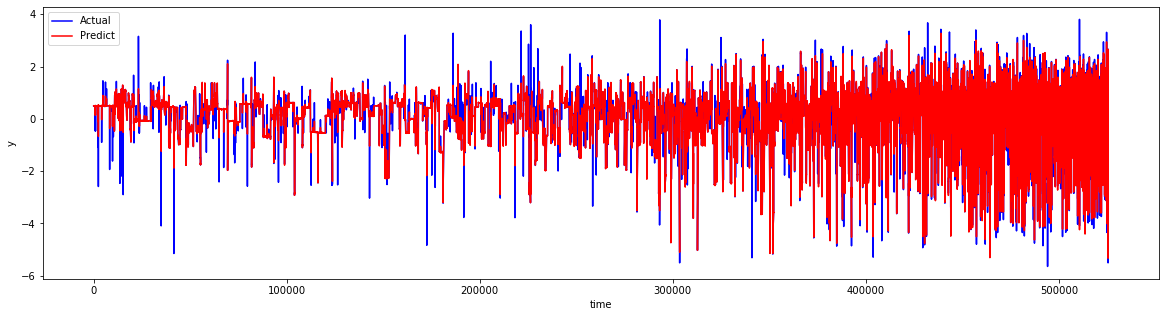

In [520]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(30)

# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
lr_model = LinearRegression()
lr_model.fit(x_train, y_train_lon)

t0 = time.time()
lr_y = y_test_lon
lr_y_fit = lr_model.predict(x_train)
lr_y_pred = lr_model.predict(x_test)
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
lr_mae = np.sum(np.absolute(lr_residuals)) / len(lr_residuals)
lr_mape = np.sum(np.absolute(lr_residuals / lr_y)) / len(lr_residuals)
print('RMSE = %.5f' % lr_rmse)
print('MAE = %.5f' % lr_mae)
print('MAPE = %.5f' % lr_mape)
print('Time to train = %.2f seconds' % (tF - t0))

plot(lr_y, lr_y_pred, True)

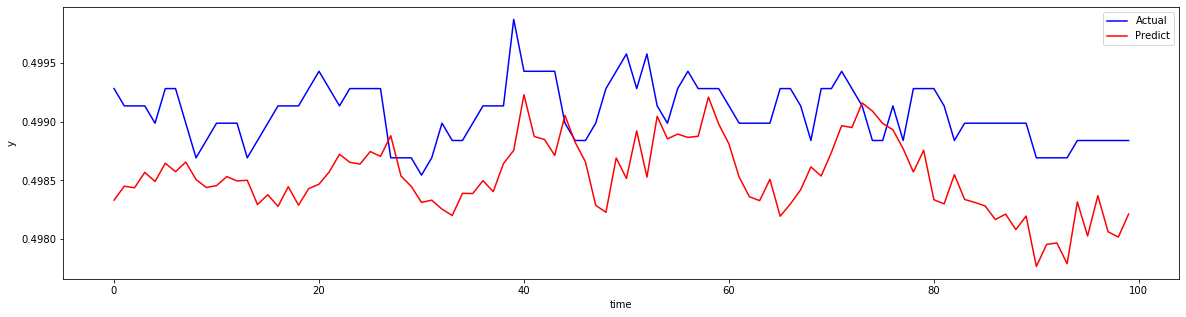

In [533]:
plot(lr_y[100:200], lr_y_pred[100:200], True)

In [517]:
x_train, y_train_lon, y_train_lat, x_test, y_test_lon, y_test_lat = experiment(40)

(2028697, 121) (2104576, 1) (506170, 121) (525587, 1)


TypeError: MLP() takes 2 positional arguments but 4 were given

In [519]:
MLP(x_train, y_train_lon, x_test, y_test_lon)

RMSE = 0.06638
MAE = 0.01065
MAPE = 0.07526
Time to train = 5.46 seconds


### Extreme Learning Machine

In [485]:
class Network(object):

    def __init__(self, input_dim, hidden_dim=10, output_dim=1):
        '''
        Neural Network object 
        '''
        self.N = input_dim 
        self.M = hidden_dim
        self.O = output_dim
        
        self.W1 = np.matrix(np.random.rand(self.N, self.M))
        self.W2 = np.matrix(np.random.rand(self.M, self.O))
        
        self.U = 0
        self.V = 0
        self.S = 0
        self.H = 0
        self.alpha = 0 # for regularization
        
    # Helper function
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-0.1 * x)) - 0.5
    
    def predict(self, x):
        '''
        Forward pass to calculate the ouput
        '''
        x = np.matrix(x)
        y = self.sigmoid(x @ self.W1) @ self.W2
        return y
    
    def train(self, x, y):
        '''
        Compute W2 that lead to minimal LS
        '''
        X = np.matrix(x)
        Y = np.matrix(y)
        self.H = np.matrix(self.sigmoid(X @ self.W1))
        H = cp.deepcopy(self.H)
        
        self.svd(H)
        iH = np.matrix(self.V) @ np.matrix(np.diag(self.S)).I @ np.matrix(self.U).T

        self.W2 = iH * Y
        print('W2 values updated..')
        return H @ self.W2 - Y
    
    def svd(self, h):
        '''
        Compute the Singular Value Decomposition of a matrix H
        '''
        H = np.matrix(h)
        self.U, self.S, Vt = np.linalg.svd(H, full_matrices=False)
        self.V = np.matrix(Vt).T
        print('SVD computed.. calculating Pseudoinverse..')
        return np.matrix(self.U), np.matrix(self.S), np.matrix(self.V)

In [493]:
import copy as cp

##############################################################
# TRAIN THE NETWORK AND PREDICT - Without previous values of y
##############################################################

in_dim = x_train.shape[1]
NN = Network(input_dim=in_dim, hidden_dim=20, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = x_train, y = y_train)
tF = time.time()

fit = NN.predict(x_train)
predictions = NN.predict(x_test)

eml_fit = cp.deepcopy(fit)
eml_pred = cp.deepcopy(predictions)

eml_residuals = eml_pred - y_test
eml_rmse = np.sqrt(np.sum(np.power(eml_residuals,2)) / len(eml_residuals))
eml_mae = np.sum(np.absolute(eml_residuals)) / len(eml_residuals)
eml_mape = np.sum(np.absolute(eml_residuals / y_test)) / len(eml_residuals)
print('RMSE = %.5f' % eml_rmse)
print('MAE = %.5f' % eml_mae)
print('MAPE = %.5f' % eml_mape)
print('Time to train %.2f' % (tF - t0))

SVD computed.. calculating Pseudoinverse..
W2 values updated..
RMSE = 0.09119
MAE = 0.03300
MAPE = 0.22855
Time to train 9.39


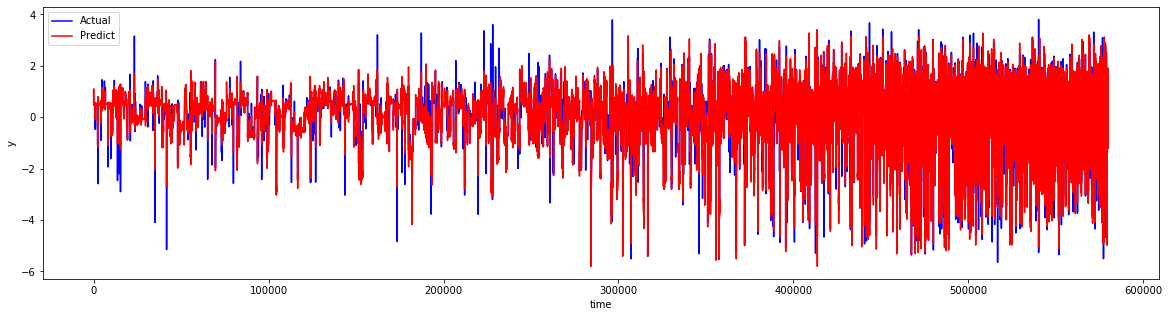

In [494]:
plot(y_test, eml_pred, True)